# Import

In [1]:
%load_ext autoreload
%autoreload 2

import fastai
from fastai import *
from fastai.tabular import *

In [2]:
fastai.__version__

'1.0.57'

# Config

In [3]:
lesson_dir_path = Path('lesson6-rossman')

In [4]:
lesson_dir_path.ls()

[PosixPath('lesson6-rossman/test_clean'),
 PosixPath('lesson6-rossman/store_states.csv'),
 PosixPath('lesson6-rossman/df'),
 PosixPath('lesson6-rossman/joined_test'),
 PosixPath('lesson6-rossman/train.csv'),
 PosixPath('lesson6-rossman/sample_submission.csv'),
 PosixPath('lesson6-rossman/store.csv'),
 PosixPath('lesson6-rossman/joined'),
 PosixPath('lesson6-rossman/train_clean'),
 PosixPath('lesson6-rossman/googletrend.csv'),
 PosixPath('lesson6-rossman/weather.csv'),
 PosixPath('lesson6-rossman/state_names.csv'),
 PosixPath('lesson6-rossman/test.csv')]

# Data preparation

In [5]:
for f in lesson_dir_path.glob('*.csv'):
    str_exec = f'df_{f.stem} = pd.read_csv(\'{f.as_posix()}\', low_memory=False)'
    print(str_exec), exec(str_exec)

df_store_states = pd.read_csv('lesson6-rossman/store_states.csv', low_memory=False)
df_train = pd.read_csv('lesson6-rossman/train.csv', low_memory=False)
df_sample_submission = pd.read_csv('lesson6-rossman/sample_submission.csv', low_memory=False)
df_store = pd.read_csv('lesson6-rossman/store.csv', low_memory=False)
df_googletrend = pd.read_csv('lesson6-rossman/googletrend.csv', low_memory=False)
df_weather = pd.read_csv('lesson6-rossman/weather.csv', low_memory=False)
df_state_names = pd.read_csv('lesson6-rossman/state_names.csv', low_memory=False)
df_test = pd.read_csv('lesson6-rossman/test.csv', low_memory=False)


fastai notebook says to convert state holiday to boolean

In [6]:
df_train.StateHoliday.unique(), df_test.StateHoliday.unique()

(array(['0', 'a', 'b', 'c'], dtype=object), array(['0', 'a'], dtype=object))

In [7]:
df_train.StateHoliday = df_train.StateHoliday != '0'

Join weather and state names

In [8]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

In [9]:
df_weather = join_df(df_weather, df_state_names, "file", "StateName")

Format google trend data

In [10]:
df_googletrend['Date'] = df_googletrend.week.str.split(' - ', expand=True)[0]
df_googletrend['State'] = df_googletrend.file.str.split('_', expand=True)[2]
df_googletrend.loc[df_googletrend.State=='NI', "State"] = 'HB,NI'

Add date features

In [11]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [12]:
add_datepart(df_weather, "Date", drop=False)
add_datepart(df_googletrend, "Date", drop=False)
add_datepart(df_train, "Date", drop=False)
add_datepart(df_test, "Date", drop=False)

Google trends has a special catagory for Germany

In [13]:
df_trend_de = df_googletrend[df_googletrend.file == 'Rossmann_DE']

Outer join all data into a single dataframe

In [14]:
df_store = join_df(df_store, df_store_states, "Store")
len(df_store[df_store.State.isnull()])

0

In [15]:
df_joined = join_df(df_train, df_store, "Store")
df_joined_test = join_df(df_test, df_store, "Store")
len(df_joined[df_joined.StoreType.isnull()]),len(df_joined_test[df_joined_test.StoreType.isnull()])

(0, 0)

In [16]:
df_joined = join_df(df_joined, df_googletrend, ["State","Year", "Week"])
df_joined_test = join_df(df_joined_test, df_googletrend, ["State","Year", "Week"])
len(df_joined[df_joined.trend.isnull()]),len(df_joined_test[df_joined_test.trend.isnull()])

(0, 0)

In [17]:
df_joined = df_joined.merge(df_trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
df_joined_test = df_joined_test.merge(df_trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(df_joined[df_joined.trend_DE.isnull()]),len(df_joined_test[df_joined_test.trend_DE.isnull()])

(0, 0)

In [18]:
df_joined = join_df(df_joined, df_weather, ["State","Date"])
df_joined_test = join_df(df_joined_test, df_weather, ["State","Date"])
len(df_joined[df_joined.Mean_TemperatureC.isnull()]),len(df_joined_test[df_joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [19]:
for df in (df_joined, df_joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

Handle missing values

In [20]:
for df in (df_joined, df_joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

Extract features from CompetitionOpenSince and CompetitionDaysOpen

In [21]:
for df in (df_joined, df_joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

Replace erroneous/outlying data

In [22]:
for df in (df_joined,df_joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

Add CompetitionMonthsOpen field

In [23]:
for df in (df_joined,df_joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
df_joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

Same process for promodates

In [24]:
from isoweek import Week
for df in (df_joined,df_joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [25]:
for df in (df_joined,df_joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [26]:
df_joined.to_pickle(lesson_dir_path/'joined')
df_joined_test.to_pickle(lesson_dir_path/'joined_test')

## Durations

Get stuff across dates

In [27]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

In [28]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [29]:
df = df_train[columns].append(df_test[columns])

In [30]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [31]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [32]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [33]:
df = df.set_index("Date")

In [34]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [35]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)

Computing rolling quantities

In [36]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [37]:
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

In [38]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [39]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [40]:
df.reset_index(inplace=True)

In [41]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [42]:
df.drop(columns,1,inplace=True)

In [43]:
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,0,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,12,0,0,0,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,11,0,0,0,0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,2015-09-14,1,10,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,2015-09-13,1,9,0,0,0,9,-1,0.0,0.0,0.0,0.0,0.0,4.0


In [44]:
df.to_pickle(lesson_dir_path/'df')

In [45]:
df["Date"] = pd.to_datetime(df.Date)

In [46]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [47]:
df_joined = pd.read_pickle(lesson_dir_path/'joined')
df_joined_test = pd.read_pickle(lesson_dir_path/f'joined_test')

In [48]:
df_joined = join_df(df_joined, df, ['Store', 'Date'])

In [49]:
df_joined_test = join_df(df_joined_test, df, ['Store', 'Date'])

In [50]:
df_joined = df_joined[df_joined.Sales!=0]

Save

In [51]:
df_joined.reset_index(inplace=True)
df_joined_test.reset_index(inplace=True)

In [52]:
df_joined.to_pickle(lesson_dir_path/'train_clean')
df_joined_test.to_pickle(lesson_dir_path/'test_clean')

# Train

In [5]:
df_train = pd.read_pickle(lesson_dir_path/'train_clean')
df_test = pd.read_pickle(lesson_dir_path/'test_clean')

In [6]:
len(df_train), len(df_test)

(844338, 41088)

In [7]:
procs=[FillMissing, Categorify, Normalize]

In [8]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [9]:
dep_var = 'Sales'
df = df_train[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [10]:
df_test['Date'].min(), df_test['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [11]:
cut = df_train['Date'][(df_train['Date'] == df_train['Date'][len(df_test)])].index.max()
cut

41395

In [12]:
valid_idx = range(cut)

In [13]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [14]:
data = (TabularList.from_df(df, path=lesson_dir_path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                   .add_test(TabularList.from_df(df_test, path=lesson_dir_path, cat_names=cat_vars, cont_names=cont_vars))
                   .databunch())

## Model

In [15]:
max_log_y = np.log(np.max(df_train['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [16]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [17]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

In [30]:
np.sum([m.weight.shape[1] for m in learn.model.embeds]) + len(cont_vars)

233

Note this matches the number of input features to the first linear layer (233)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


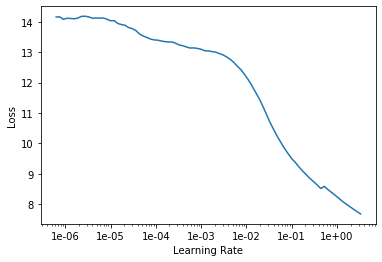

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.024804,0.026000,0.169101,01:20
1,0.019994,0.017556,0.124250,01:23
2,0.016284,0.022940,0.139025,01:22
3,0.013422,0.012561,0.108446,01:23
4,0.009868,0.011333,0.104379,01:22


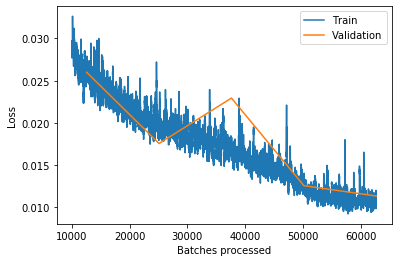

In [38]:
learn.recorder.plot_losses(skip_start=10000)

In [39]:
learn.save('1')